# Week of 2025.06.02

## TODO
- [ ] Model 1D conduit. Make the atmosphere also 1D. Figure out what level of resolution is required to get an accurate atmosphere simulation. 
- [ ] Compare analytical and numerical results.

## Vertical conduit mesh

Our first goal this week is to create a vertical mesh to simplify the simulation and verify that the wave properties behave as intended. 

In [9]:
from helper_code.slip_imports import *
from helper_code.helper_functions import get_local_solver_from_index_func
from helper_code.animate import animate_conduit_pressure

import helper_code.infrasound as infrasound
from matplotlib.animation import FuncAnimation

import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'

folder_name = "simple_conduit"

/Users/paxton/git/quail_volcano/src

Points: (1054, 3)
Cells: dict_keys(['line', 'triangle'])
Cell Sets: {}


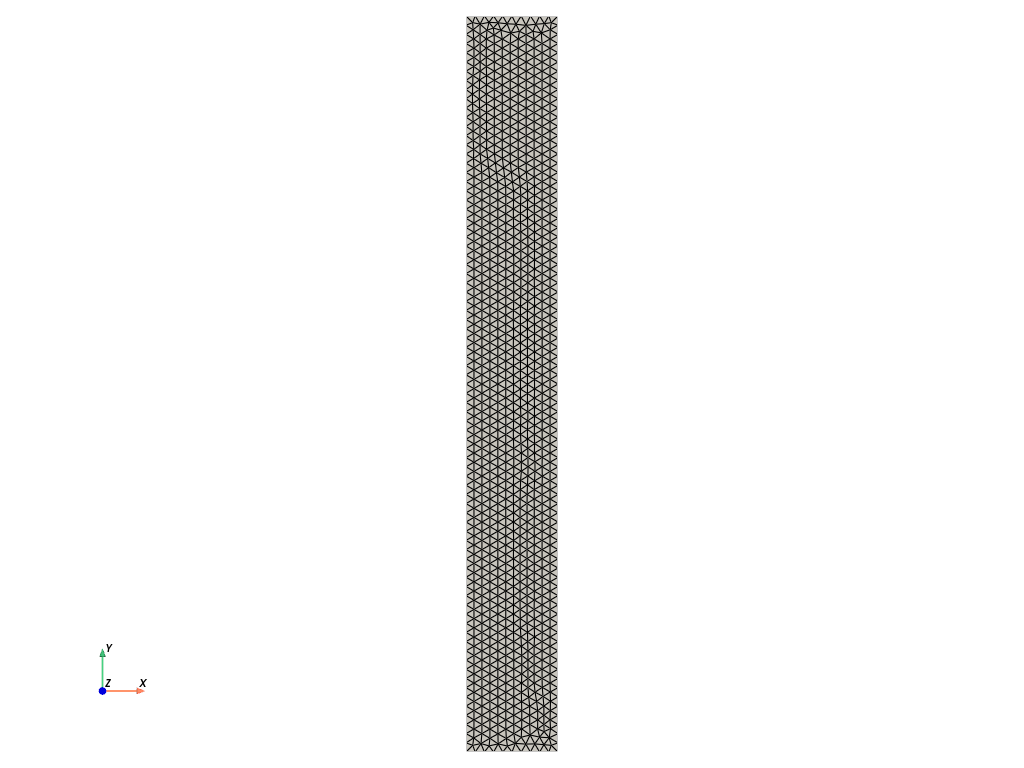

In [38]:
import meshio
import pyvista as pv
import os

print(os.getcwd())

mesh = meshio.read(f"{BASE_PATH}/quail_volcano/scenarios/meshes/vertical_conduit.msh")

# Clear cell sets to avoid the error
mesh.cell_sets.clear()

# Print mesh details
print("Points:", mesh.points.shape)
print("Cells:", mesh.cells_dict.keys())
#for cell_type, cell_data in mesh.cells_dict.items():
    #print(f"Cell type {cell_type}: {cell_data.shape}")
print("Cell Sets:", mesh.cell_sets)
#print("Cell Data:", mesh.cell_data)

pv.set_jupyter_backend('static')

# Convert to pyvista mesh
pv_mesh = pv.from_meshio(mesh)

# Create a plotter and visualize
plotter = pv.Plotter()

plotter.add_mesh(pv_mesh, show_edges=True, color="white")
plotter.set_scale(xscale=1.0, yscale=1.0, zscale=1.0)
plotter.camera.roll += 80

plotter.view_xy()  # For 2D meshes; use view_isometric() for 3D
plotter.show_axes()
plotter.show()

## Let's then review the "eruption" we are experimenting with. 

In [34]:
from helper_code.slip_imports import *
from helper_code.helper_functions import get_local_solver_from_index_func
from helper_code.animate import animate_conduit_pressure

import helper_code.infrasound as infrasound
from matplotlib.animation import FuncAnimation

import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'

folder_name = "simple_conduit"

ITERS = 50
D_ITERS = 1
END_TIME = 20
C0 = 320 # m/s at 5000m

In [ ]:
file_name = "short_plug_v12"
iters = 50
solver_func = get_local_solver_from_index_func(folder_name, file_name)
ani = animate_conduit_pressure(
    solver_func,
    iterations=iters,
    d_iterations=D_ITERS,
    viscosity_index=2,
    wall_friction_index=1,
    max_velocity=5,
    max_slip=60,
    max_tau=1.5,
    max_pressure=50,
    max_speed_of_sound=1000,
    max_water=1,
    max_density=5e3,
    max_fragmentation=5000,
    max_crystal=100,
    max_viscosity=0.1,
)

ani.save(
    f"{BASE_PATH}/volcano_sims/notebooks/animations/small_controlled_eruption.mp4",
    writer="ffmpeg",
    fps=10,
    bitrate=1800,
)
HTML(ani.to_html5_video())

## And the the specific eruption and atmosphere of our simple model looks like this

In [39]:
file_name = "short_plug_v16"
iters = 9
solver_func = get_local_solver_from_index_func(folder_name, file_name)
ani = animate_conduit_pressure(
    solver_func,
    iterations=iters,
    d_iterations=D_ITERS,
    viscosity_index=2,
    wall_friction_index=1,
    max_velocity=5,
    max_slip=60,
    max_tau=1.5,
    max_pressure=50,
    max_speed_of_sound=1000,
    max_water=1,
    max_density=5e3,
    max_fragmentation=5000,
    max_crystal=100,
    max_viscosity=0.1,
)

ani.save(
    f"{BASE_PATH}/volcano_sims/notebooks/animations/small_controlled_eruption.mp4",
    writer="ffmpeg",
    fps=10,
    bitrate=1800,
)
HTML(ani.to_html5_video())

In [41]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
import numpy as np
import processing.mdtools as mdtools

iterations = 9

# Assume solver2D_from is available as in the original code
solver2D_atm1 = get_local_solver_from_index_func("simple_conduit", "test_infrasound_vertical_conduit_atm1")

# Set up figure
fig = plt.figure(figsize=(8, 6))

# Define pressure range for colormap
clims = (-1e3, 1e3)

# Set up colorbar
sm = plt.cm.ScalarMappable(
    norm=colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap()
)
cb = plt.colorbar(sm, ax=plt.gca())
cb.set_label("Pressure (Pa)")
x1, p1_0= mdtools.downsample(solver2D_atm1(0), plot_qty="Pressure")

# Animation update function
def update(frame):
    plt.cla()  # Clear current axis
    # Fetch data for current frame
    x1, p1= mdtools.downsample(solver2D_atm1(frame), plot_qty="Pressure")
    # Update plot
    mdtools.plot_mean(x1, p1 - p1_0, clims)
    plt.title(f"Order 1: Pressure Field at t= {round(solver2D_atm1(frame).time)}")
    return plt.gca(),

# Create animation
# Assume 100 frames for simulation; adjust based on solver data
ani = animation.FuncAnimation(
    fig,
    update,
    frames=range(0, iterations, 1),  # Adjust range based on available solver indices
    interval=100,  # Time between frames in milliseconds
    blit=False
)

display(HTML(ani.to_html5_video()))
ani.save(f'{BASE_PATH}/volcano_sims/notebooks/animations/quail_small_eruption.mp4', writer='ffmpeg', fps=10, bitrate=1800)
plt.close(fig)  # Clean up